# Prepoznavanje vozne trake

## Algoritam se sastoji od 2 glavna dijela:
### 1. Obrada slike koja za rezultat daje binarnu sliku koja predstavlja masku voznih traka
### Korak 1: Kalibracija kamere
### Korak 2: Označavanje ROI-a (Region of Interes) i obavljanje perspektivne transformacije na ROI
### Korak 3: Obrada slike unutar ROI
### 2. Obrada binarne slike nakon koje dobijemo dva pravca koja predstavljaju vozne trake

# 1. Obrada slike koja za rezultat daje binarnu sliku koja predstavlja masku voznih traka

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
print('Imports done')

Imports done


## Korak 1: Kalibracija kamere 
## U ovom koraku se uklanja distorzija (zaobljenje) slike uzrokovano fizičkom lećom na kameri

Original Image


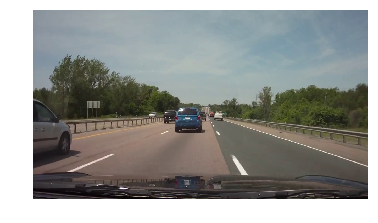

In [2]:
exampleImg = cv2.imread('./Test_images/dashcam_driving/frame117.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
plt.imshow(exampleImg)
plt.axis('off')
print('Original Image')

Prikaz originalne slike

Definiranje funkcije koja vrši uklanjanje distorzije

In [3]:
#Constants used for image undistortion, calculated in another function 
mtx = np.array([[1.15694035e+03, 0.00000000e+00, 6.65948597e+02],[0.00000000e+00, 1.15213869e+03, 3.88785178e+02],[0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],np.float64)
dist = np.array([-2.37636612e-01, -8.54129776e-02, -7.90955950e-04, -1.15908700e-04, 1.05741395e-01],np.float64)


def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

Konstante su kopirane iz prethodno obavljene funkcije koja je izračunala koeficijente

## Prikaz slike nakon uklanjanja distorzije slike uzrokovano lećom na kameri

...


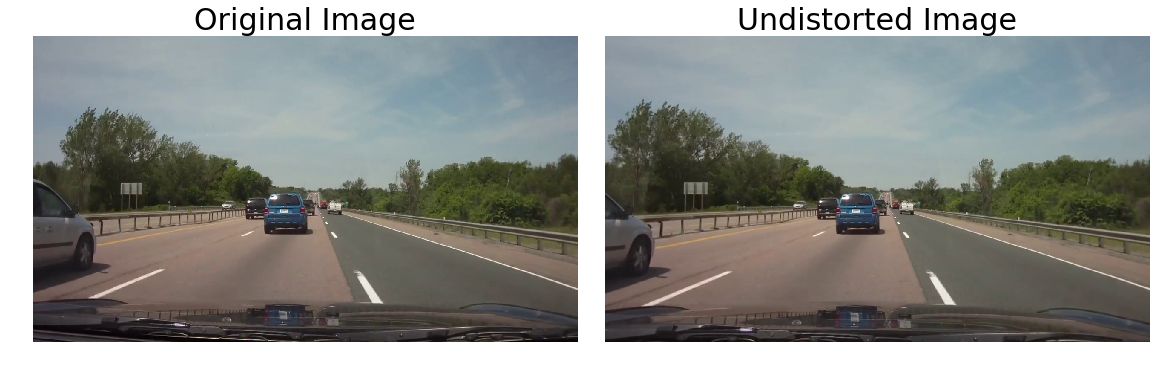

In [4]:
exampleImg_undistort = undistort(exampleImg)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')

ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')
print('...')



Promjena je vidljiva na dnu slika kod haube.

# Korak 2: Označavanje ROI-a (Region of Interes) i obavljanje perspektivne transformacije na ROI

Definiranje funkcije koja vrši perspektivnu transformaciju

In [5]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
print('...')


...


src - sadrži dimenzije trapeza (koordinate 4 točke na slici) koji se uzima iz originalne slike i na kojem se vrši perspektivna transformacija
dst - sadrži koordinate odredišnih točaka nakon transformacije. Ovdje je u pitanju kvadrat.

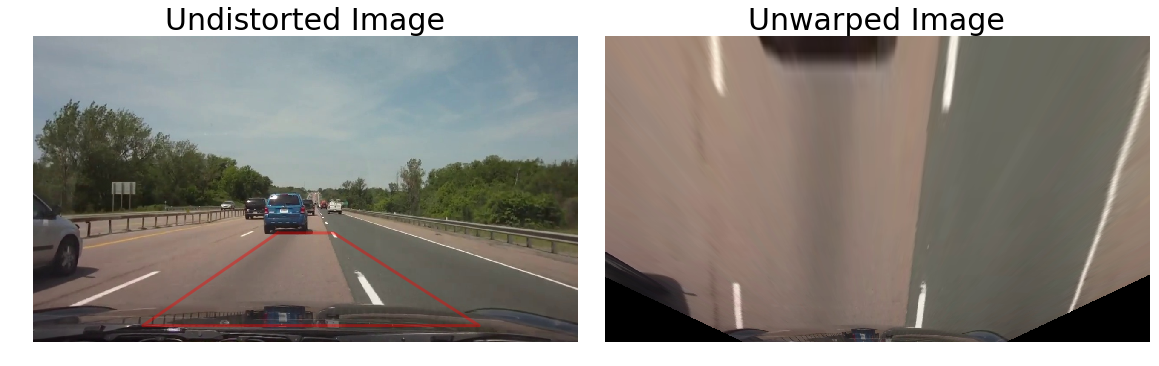

In [6]:
h,w = exampleImg_undistort.shape[:2]

src = np.float32([(575,464),
                  (707,464),
                  (258,682),
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

exampleImg_unwarp, M, Minv = unwarp(exampleImg_undistort, src, dst)


# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.axis('off')
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)
ax2.axis('off')

print('')

# Korak 3: Obrada slike unutar ROI

## Cilj je dobiti binarnu sliku koja prikazuje samo linije

Konverzija slike u različite colorspace-ove

...


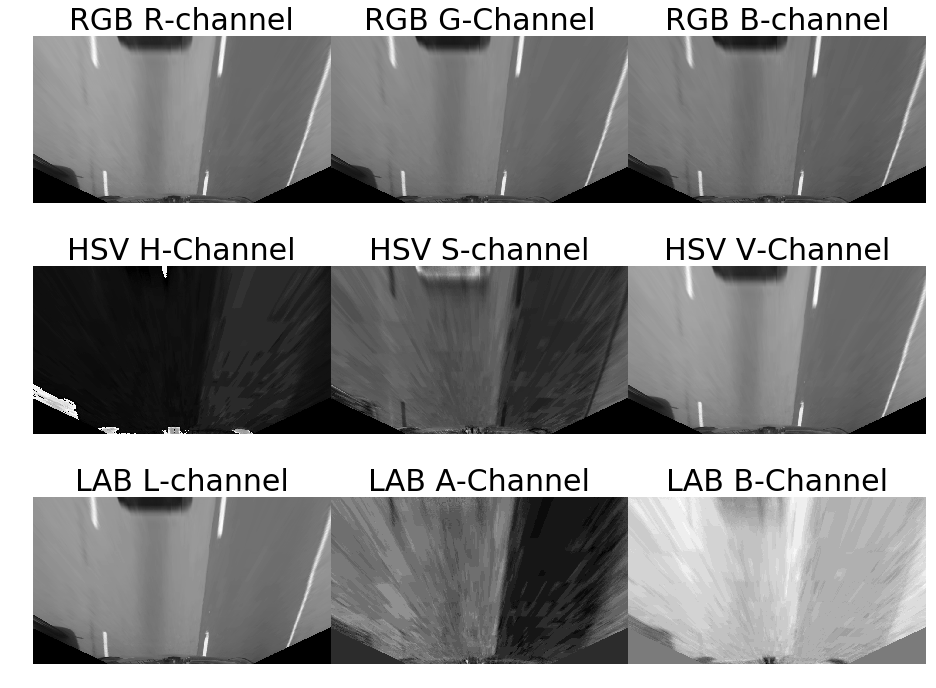

In [7]:
# Visualising multiple color space channels
exampleImg_unwarp_R = exampleImg_unwarp[:,:,0]
exampleImg_unwarp_G = exampleImg_unwarp[:,:,1]
exampleImg_unwarp_B = exampleImg_unwarp[:,:,2]
exampleImg_unwarp_HSV = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HSV)
exampleImg_unwarp_H = exampleImg_unwarp_HSV[:,:,0]
exampleImg_unwarp_S = exampleImg_unwarp_HSV[:,:,1]
exampleImg_unwarp_V = exampleImg_unwarp_HSV[:,:,2]
exampleImg_unwarp_LAB = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2Lab)
exampleImg_unwarp_L = exampleImg_unwarp_LAB[:,:,0]
exampleImg_unwarp_A = exampleImg_unwarp_LAB[:,:,1]
exampleImg_unwarp_B2 = exampleImg_unwarp_LAB[:,:,2]

fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(exampleImg_unwarp_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=30)
axs[0].axis('off')
axs[1].imshow(exampleImg_unwarp_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=30)
axs[1].axis('off')
axs[2].imshow(exampleImg_unwarp_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=30)
axs[2].axis('off')
axs[3].imshow(exampleImg_unwarp_H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=30)
axs[3].axis('off')
axs[4].imshow(exampleImg_unwarp_S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=30)
axs[4].axis('off')
axs[5].imshow(exampleImg_unwarp_V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=30)
axs[5].axis('off')
axs[6].imshow(exampleImg_unwarp_L, cmap='gray')
axs[6].set_title('LAB L-channel', fontsize=30)
axs[6].axis('off')
axs[7].imshow(exampleImg_unwarp_A, cmap='gray')
axs[7].set_title('LAB A-Channel', fontsize=30)
axs[7].axis('off')
axs[8].imshow(exampleImg_unwarp_B2, cmap='gray')
axs[8].set_title('LAB B-Channel', fontsize=30)
axs[8].axis('off')
print('...')

Definiranje funkcije za sobel threshold i ispisivanje rezultata na slici

In [8]:
# Defining a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
print('...')

...


...


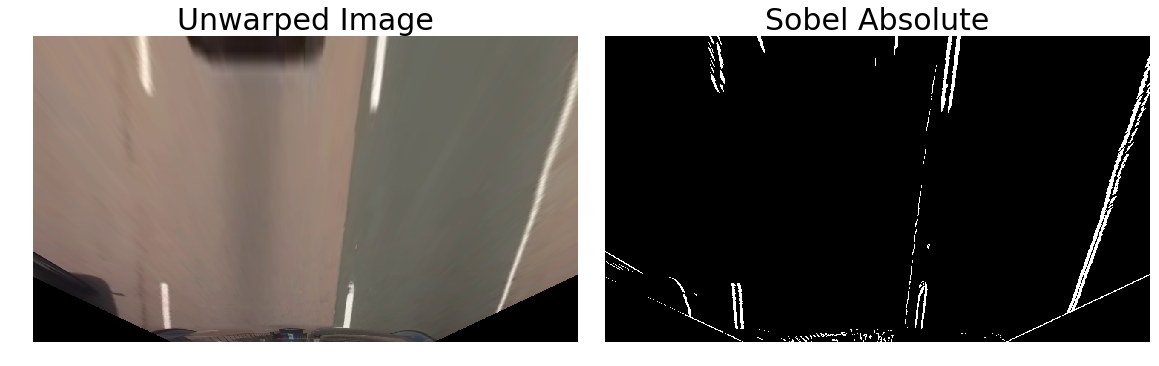

In [9]:
min_thresh=25
max_thresh=255
exampleImg_sobelAbs = abs_sobel_thresh(exampleImg_unwarp, 'x', min_thresh, max_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_sobelAbs, cmap='gray')
ax2.set_title('Sobel Absolute', fontsize=30)
ax2.axis('off')
print('...')

Definiranje funkcije za sobel magnitude i ispisivanje rezultata na slici

In [10]:
# Defining a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output
print('...')

...


...


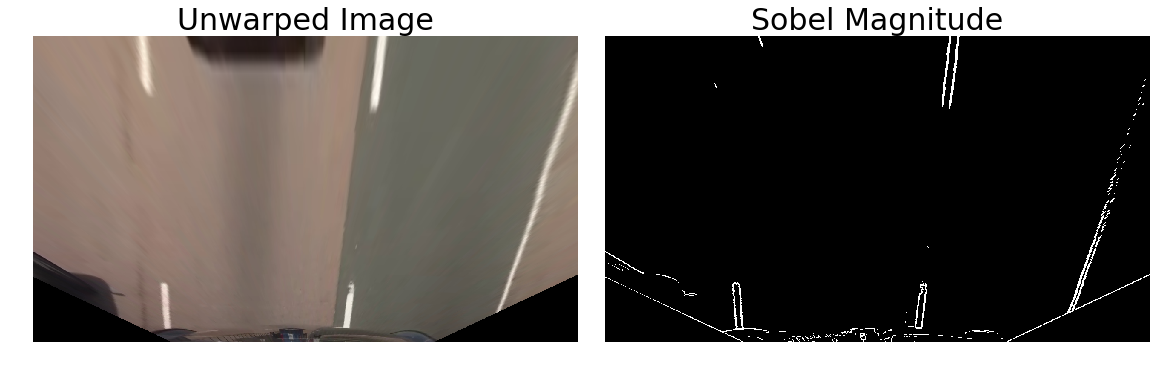

In [11]:
min_thresh=25
max_thresh=255
kernel_size=25


exampleImg_sobelMag = mag_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
# Visualize sobel magnitude threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_sobelMag, cmap='gray')
ax2.set_title('Sobel Magnitude', fontsize=30)
ax2.axis('off')
print('...')

Definiranje funkcije za sobel direction threshold i ispisivanje rezultata na slici

In [12]:
# Defining a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
print('...')

...


...


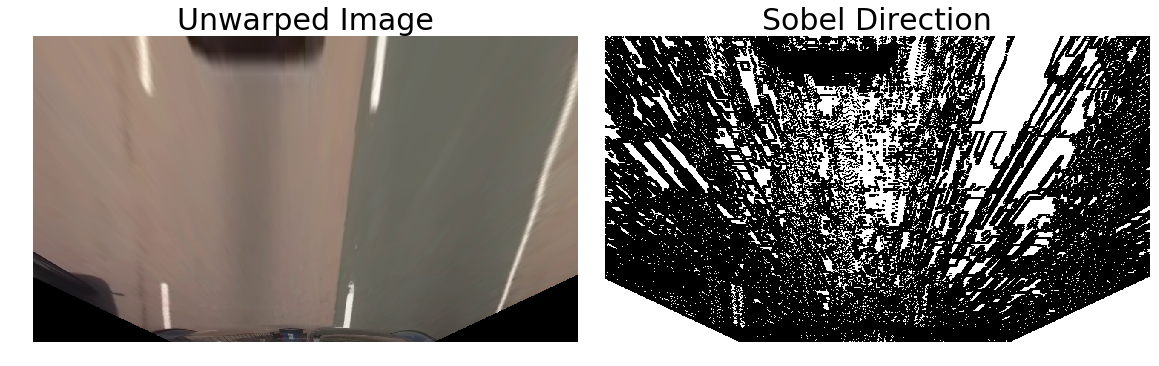

In [13]:
min_thresh=0
max_thresh=0.11
kernel_size=7

exampleImg_sobelDir = dir_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
# Visualize sobel direction threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_sobelDir, cmap='gray')
ax2.set_title('Sobel Direction', fontsize=30)
ax2.axis('off')
    
print('...')

Definiranje funkcije za HLS s-kanal threshold i ispisivanje rezultata na slici

In [14]:
# Defining a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


...


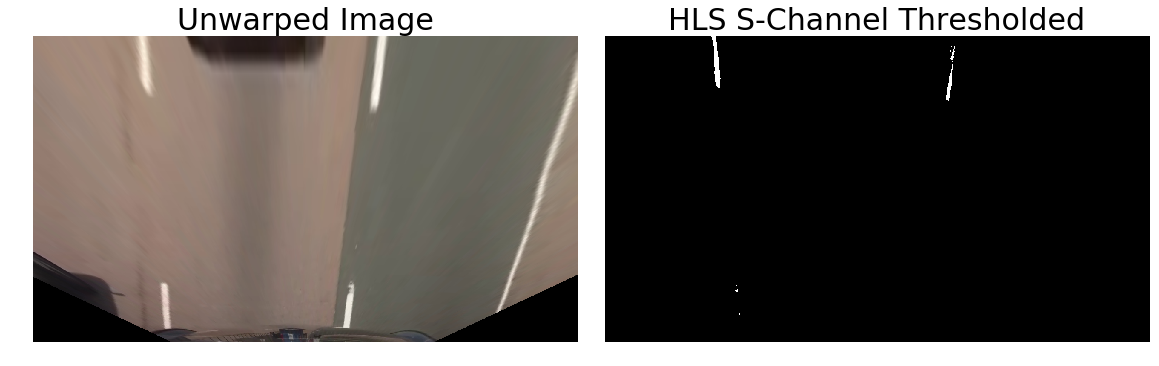

In [15]:


exampleImg_SThresh = hls_sthresh(exampleImg_unwarp)
# Visualize hls s-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_SThresh, cmap='gray')
ax2.set_title('HLS S-Channel Thresholded', fontsize=30)
ax2.axis('off')
    
print('...')

Definiranje funkcije za HLS l-kanal threshold i ispisivanje rezultata na slici

In [16]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

print('...')

...


...


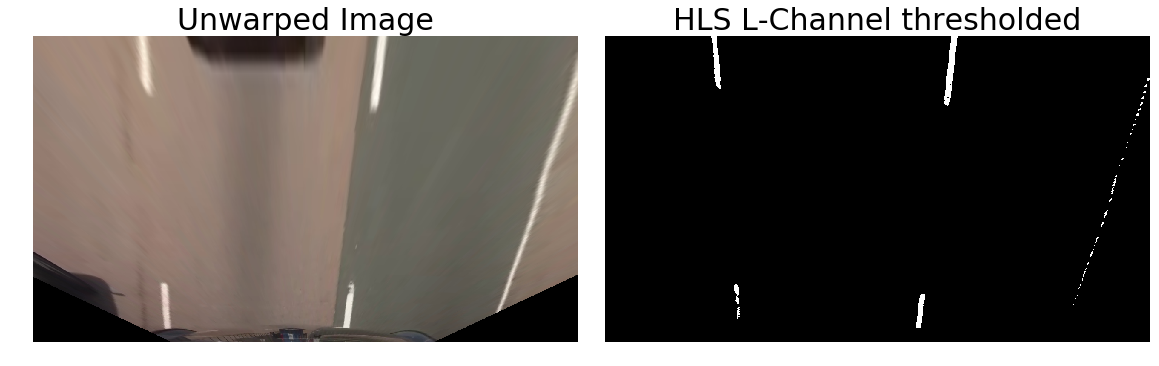

In [17]:
exampleImg_LThresh = hls_lthresh(exampleImg_unwarp)
# Visualize hls l-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_LThresh, cmap='gray')
ax2.set_title('HLS L-Channel thresholded', fontsize=30)
ax2.axis('off')   
print('...')

Definiranje funkcije za LAB B-kanal threshold i ispisivanje rezultata na slici

In [18]:
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

...


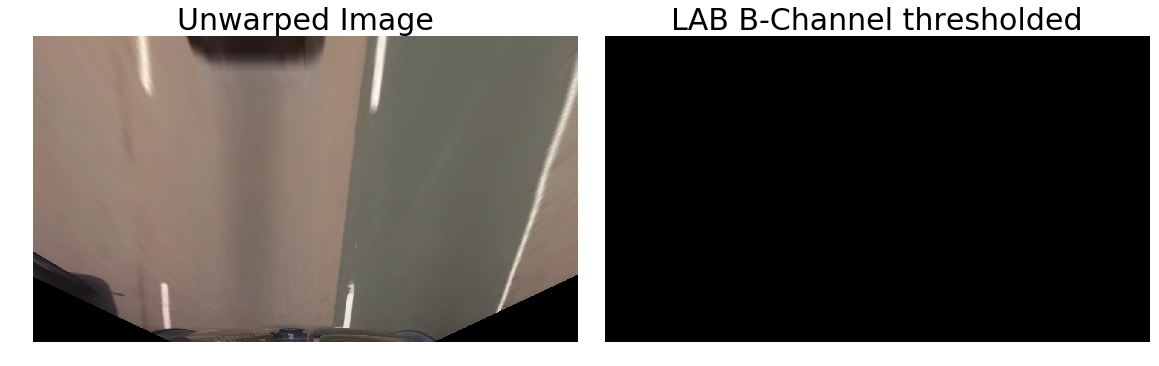

In [19]:
exampleImg_BThresh = lab_bthresh(exampleImg_unwarp, (min_thresh, max_thresh))
# Visualize hls l-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_BThresh, cmap='gray')
ax2.set_title('LAB B-Channel thresholded', fontsize=30)
ax2.axis('off')   
print('...')

Definiranje funkcije za LAB L-kanal threshold i ispisivanje rezultata na slici

In [20]:
def lab_lthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,0]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

...


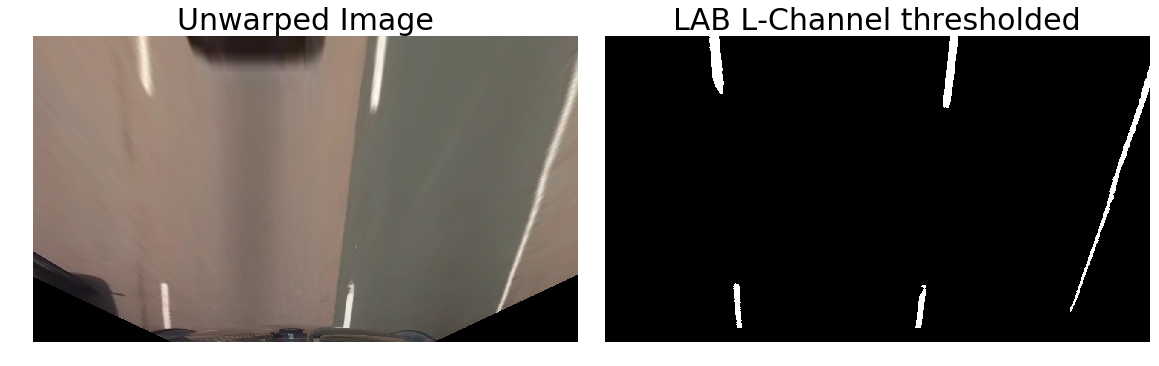

In [21]:
exampleImg_LLThresh = lab_lthresh(exampleImg_unwarp)
# Visualize hls l-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_LLThresh, cmap='gray')
ax2.set_title('LAB L-Channel thresholded', fontsize=30)
ax2.axis('off')   
print('...')

Definiranje funkcije za RGB R,B,G-kanal threshold i ispisivanje rezultata na slici

In [22]:
def rgb_thresh(img, thresh=(200, 255), color = 0):
    # 1) Convert to HLS color space
    #rgb = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(img[:,:,color])
    binary_output[(img[:,:,color] > thresh[0]) & (img[:,:,color] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

...


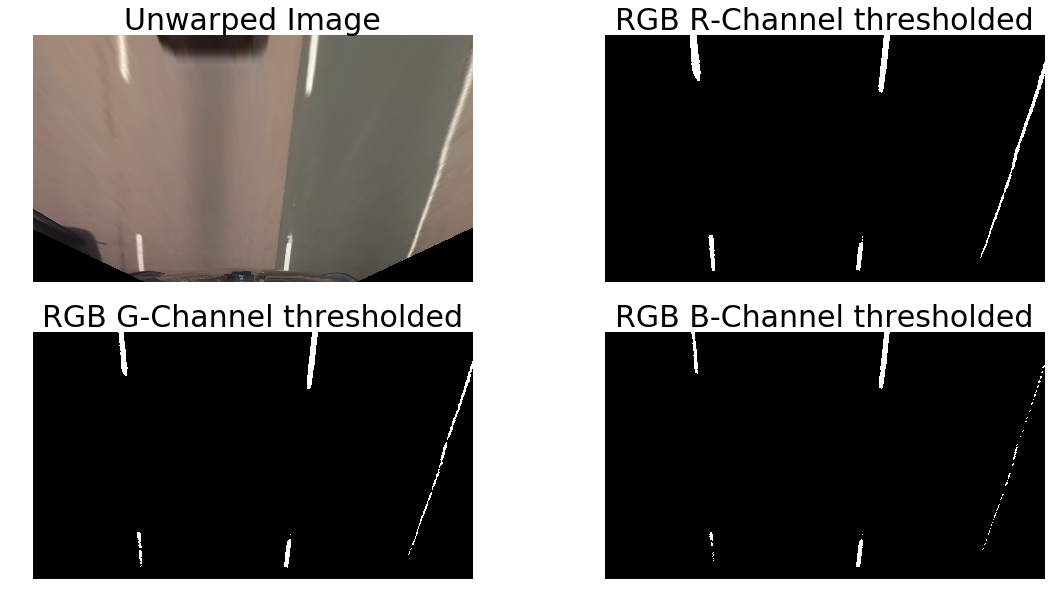

In [23]:
exampleImg_R_RGBThresh = rgb_thresh(exampleImg_unwarp,color=0)
exampleImg_G_RGBThresh = rgb_thresh(exampleImg_unwarp,color=1)
exampleImg_B_RGBThresh = rgb_thresh(exampleImg_unwarp,color=2)
# Visualize hls l-channel threshold
f, ax = plt.subplots(2, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax[0,0].imshow(exampleImg_unwarp)
ax[0,0].set_title('Unwarped Image', fontsize=30)
ax[0,0].axis('off')

ax[0,1].imshow(exampleImg_R_RGBThresh, cmap='gray')
ax[0,1].set_title('RGB R-Channel thresholded', fontsize=30)
ax[0,1].axis('off')

ax[1,0].imshow(exampleImg_G_RGBThresh, cmap='gray')
ax[1,0].set_title('RGB G-Channel thresholded', fontsize=30)
ax[1,0].axis('off')

ax[1,1].imshow(exampleImg_B_RGBThresh, cmap='gray')
ax[1,1].set_title('RGB B-Channel thresholded', fontsize=30)
ax[1,1].axis('off')

print('...')

Kombiniranje dobivenih maska

In [24]:
sobelMag_sobelDir = np.zeros_like(exampleImg_sobelMag)
sobelMag_sobelDir[((exampleImg_sobelMag == 1) & (exampleImg_sobelDir == 1))] = 1

sobelAbs_sobelDir = np.zeros_like(exampleImg_sobelAbs)
sobelAbs_sobelDir[((exampleImg_sobelAbs == 1) & (exampleImg_sobelDir == 1))] = 1

sobelMag_sobelAbs = np.zeros_like(exampleImg_sobelMag)
sobelMag_sobelAbs[((exampleImg_sobelMag == 1) & (exampleImg_sobelAbs == 1))] = 1

combined_HLSl_LABb = np.zeros_like(exampleImg_BThresh)
combined_HLSl_LABb[((exampleImg_BThresh == 1) | (exampleImg_LThresh == 1))] = 1

combined_HLSs_LABb = np.zeros_like(exampleImg_SThresh)
combined_HLSs_LABb[((exampleImg_BThresh == 1) | (exampleImg_SThresh == 1))] = 1

combined_HLSl_SOBELabs = np.zeros_like(exampleImg_LThresh)
combined_HLSl_SOBELabs[((exampleImg_LThresh==1)|(exampleImg_sobelAbs==1))]=1

combined_HLSl_SOBELmag = np.zeros_like(exampleImg_LThresh)
combined_HLSl_SOBELmag[((exampleImg_LThresh==1)|(exampleImg_sobelMag==1))]=1

combined_HLSl_HLSs = np.zeros_like(exampleImg_LThresh)
combined_HLSl_HLSs[((exampleImg_LThresh==1)|(exampleImg_SThresh==1))]=1

combined_LABl_HLSs = np.zeros_like(exampleImg_LLThresh)
combined_LABl_HLSs[((exampleImg_LLThresh==1)|(exampleImg_SThresh==1))]=1


...


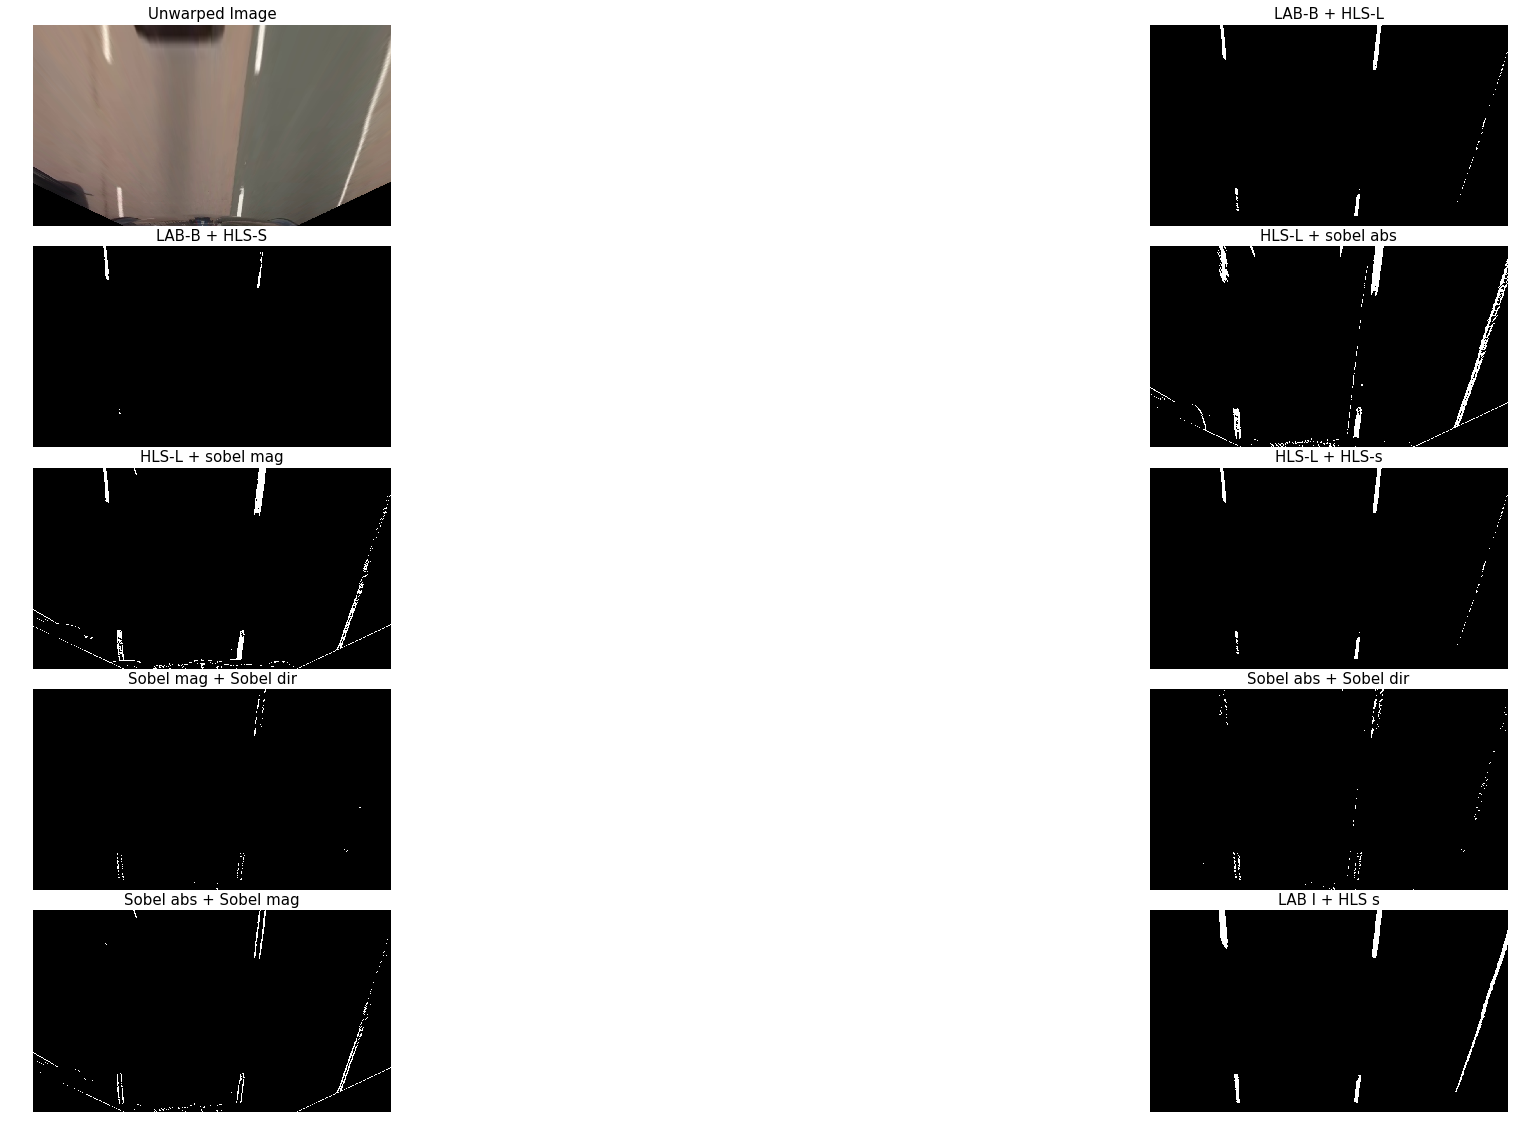

In [25]:
ff, axx = plt.subplots(5, 2, figsize=(40,20))
ff.subplots_adjust(hspace = .1, wspace=0.001)

axx[0,0].imshow(exampleImg_unwarp)
axx[0,0].axis('off')
axx[0,0].set_title('Unwarped Image', fontsize=15)

axx[0,1].imshow(combined_HLSl_LABb,cmap='gray')
axx[0,1].axis('off')
axx[0,1].set_title('LAB-B + HLS-L', fontsize=15)

axx[1,0].imshow(combined_HLSs_LABb,cmap='gray')
axx[1,0].axis('off')
axx[1,0].set_title('LAB-B + HLS-S', fontsize=15)

axx[1,1].imshow(combined_HLSl_SOBELabs,cmap='gray')
axx[1,1].axis('off')
axx[1,1].set_title('HLS-L + sobel abs', fontsize=15)

axx[2,0].imshow(combined_HLSl_SOBELmag,cmap='gray')
axx[2,0].axis('off')
axx[2,0].set_title('HLS-L + sobel mag', fontsize=15)

axx[2,1].imshow(combined_HLSl_HLSs,cmap='gray')
axx[2,1].axis('off')
axx[2,1].set_title('HLS-L + HLS-s', fontsize=15)

axx[3,0].imshow(sobelMag_sobelDir,cmap='gray')
axx[3,0].axis('off')
axx[3,0].set_title('Sobel mag + Sobel dir', fontsize=15)

axx[3,1].imshow(sobelAbs_sobelDir,cmap='gray')
axx[3,1].axis('off')
axx[3,1].set_title('Sobel abs + Sobel dir', fontsize=15)

axx[4,0].imshow(sobelMag_sobelAbs,cmap='gray')
axx[4,0].axis('off')
axx[4,0].set_title('Sobel abs + Sobel mag', fontsize=15)

axx[4,1].imshow(combined_LABl_HLSs,cmap='gray')
axx[4,1].axis('off')
axx[4,1].set_title('LAB l + HLS s', fontsize=15)

print('...')

Od dobivenih binarnih slika uzimamo jednu te ju dalje prosljeđujemo u sljedeći dio algoritma

#  2. Obrada binarne slike nakon koje dobijemo dva pravca koja predstavljaju vozne trake

Uzimamo binarnu sliku i radimo histogram po x osi

...


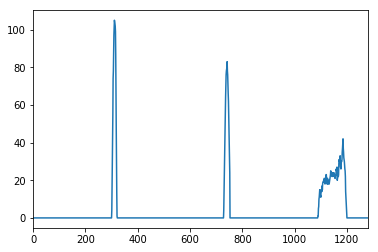

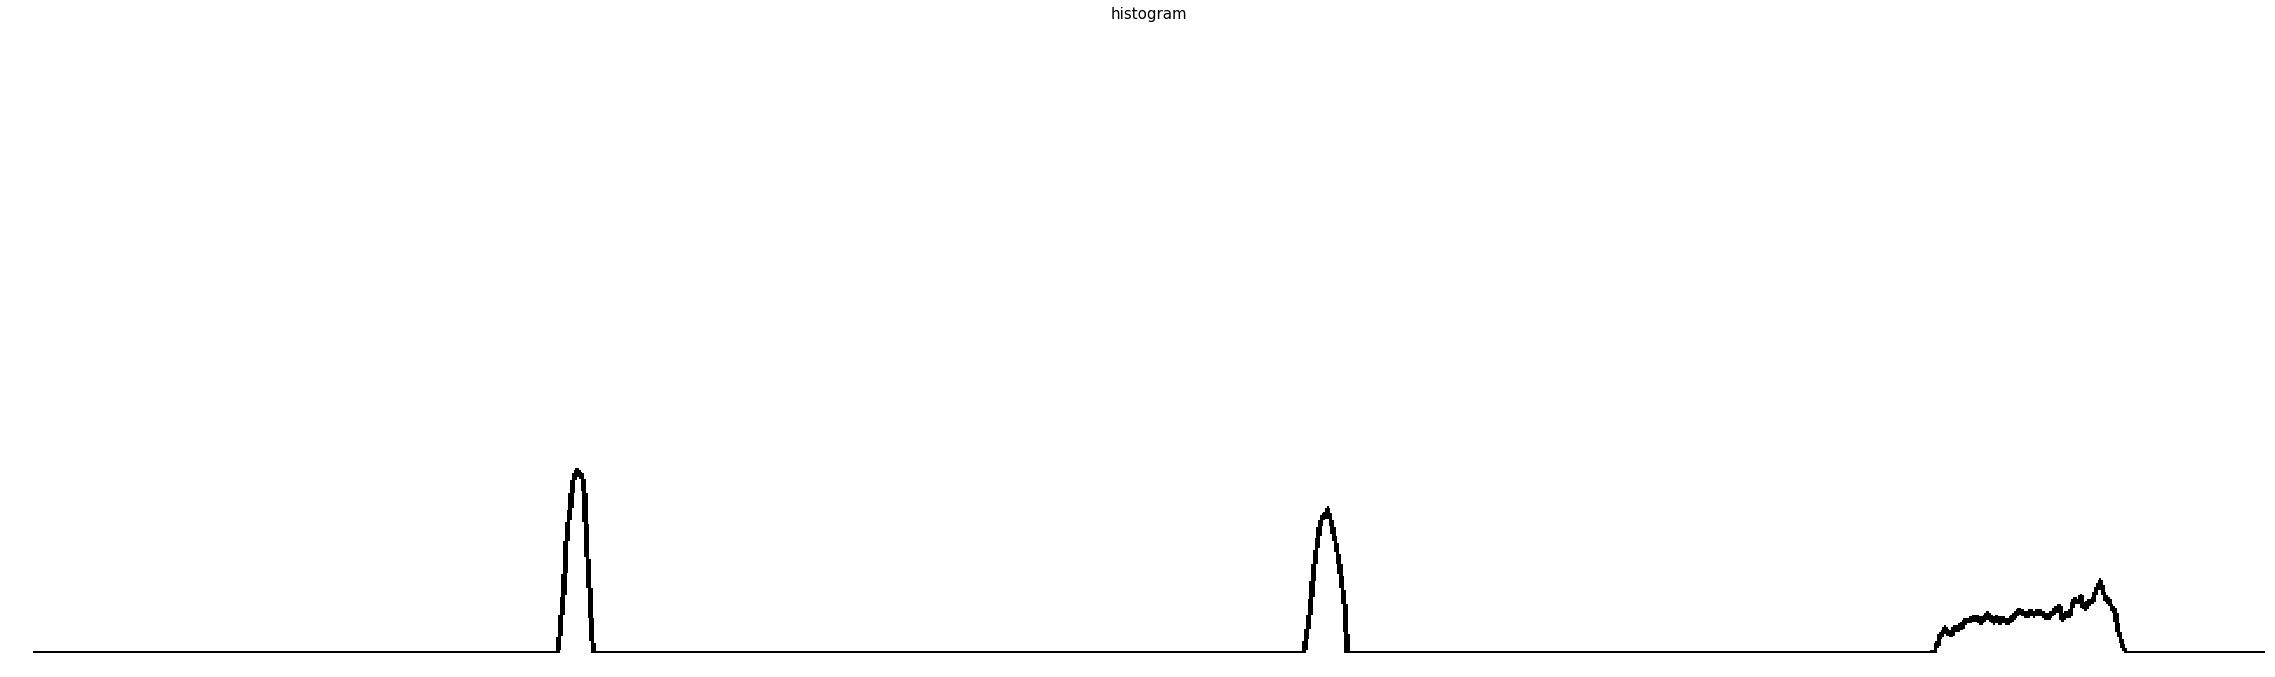

In [26]:
binary_image=combined_LABl_HLSs

histogram = np.sum(binary_image[binary_image.shape[0]//2:,:], axis=0)
# print(histogram.shape[0])
# print(histogram.dtype)

plt.plot(histogram)
plt.xlim(0, 1280)

#histogram_image=np.zeros_like(binary_image,dtype=int)
histogram_image=np.ones((binary_image.shape[0]//2,binary_image.shape[1]),dtype=int)
out_image = np.uint8(np.dstack((histogram_image, histogram_image, histogram_image))*255)

i=1
while i <= len(histogram)-1:
    cv2.line(out_image,(i-1,histogram_image.shape[0]-int(histogram[i-1])),(i,histogram_image.shape[0]-int(histogram[i])),(0,0,0),2)
    i+=1
    
ff, axx = plt.subplots(1, figsize=(40,20))
ff.subplots_adjust(hspace = .1, wspace=0.001)
axx.imshow(out_image,cmap='gray')
axx.axis('off')
axx.set_title('histogram', fontsize=15)

print('...')

Zatim pomoću histograma uzimamo 2 pozicije koje imaju najveću vrijednost
tj. položaje gdje ima najviše bijelih točaka na binarnoj slici po x osi

Uz to definiramo sve varijable potrebne za izračune

In [27]:
#finding the middle point of histogram
midpoint = np.int(histogram.shape[0]//2)
#finding the quarter of histogram
quarter_point = np.int(midpoint//2)
    
#with middle and quarter point, make left and right base positions
# leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
# rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9
# Height of windows
window_height = np.int(binary_image.shape[0]/nwindows)
    
# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])   

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 40

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
# Rectangle data for visualization
rectangle_data = []

Određujemo i crtamo prozore (pravokutnike) oko 2 vrijednosti gdje ima najviše bijelih točaka na binarnoj slici po x osi

Uz to računamo i mijenjamo (pomičemo) x i y koordinate prozora ako u prozoru postoji broj bijelih točaka veći od minpix. Pomičemo u lijevo ili desno pomoću određivanja srednje vrijednosti.

...


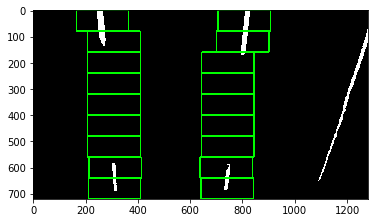

In [28]:
out_img=np.copy(binary_image)
out_img = np.uint8(np.dstack((binary_image, binary_image, binary_image))*255)

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_image.shape[0] - (window+1)*window_height
    win_y_high = binary_image.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)
    rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        
        
 
plt.imshow(out_img)
print('...')

In [29]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

left_fit, right_fit = (None, None)
# Fit a second order polynomial to each
if len(leftx) != 0:
    left_fit = np.polyfit(lefty, leftx, 2)
if len(rightx) != 0:
    right_fit = np.polyfit(righty, rightx, 2)

visualization_data = (rectangle_data, histogram)

#return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
print('...')

...


...


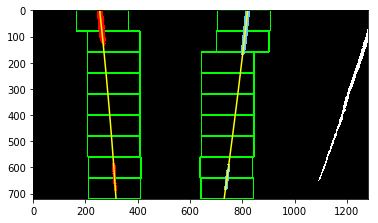

In [30]:
# visualize the result on binary image

h = binary_image.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((binary_image, binary_image, binary_image))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 3) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 3) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print('...')